# Claytor Neural Network Model


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from cm import plot_confusion_matrix
import pickle

## Prep Training Data

In [6]:
# bring in the participants data
participants_train = pd.read_csv('../data/participants_train.csv')

# bring in the champion_mastery info
champion_mastery = pd.read_csv('../data/champion_mastery.csv')

# merge champion mastery info in
df = pd.merge(participants_train, champion_mastery, on = ['championId', 'summonerId'])

# bring in stats data from the 10-minute mark
stats = pd.read_pickle('../data/ten_min_stats.pkl')#.drop(columns = 'Unnamed: 0')

# merge in stats
df = (
    pd.merge(df, 
             stats, 
             on = ['matchId', 'participantId'])
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78269 entries, 0 to 78268
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   matchId         78269 non-null  int64 
 1   teamId          78269 non-null  int64 
 2   participantId   78269 non-null  int64 
 3   summonerId      78269 non-null  int64 
 4   summonerLevel   78269 non-null  int64 
 5   championName    78269 non-null  object
 6   championId      78269 non-null  int64 
 7   championLevel   78269 non-null  int64 
 8   championPoints  78269 non-null  int64 
 9   chestGranted    78269 non-null  bool  
 10  tokensEarned    78269 non-null  int64 
 11  total_gold      78269 non-null  int64 
 12  xp              78269 non-null  int64 
 13  level           78269 non-null  int64 
 14  position        78269 non-null  object
 15  champ_stats     78269 non-null  object
 16  damage_stats    78269 non-null  object
 17  timestamp       78269 non-null  int64 
dtypes: boo

In [12]:
# aggregate team stats
team_stats = (
    df
    .groupby(['matchId', 'teamId'])
    .agg(champion_level = ('championLevel', 'sum'),
         champion_points = ('championPoints', 'sum'),
         total_gold = ('total_gold', 'sum'),
         total_xp = ('xp', 'sum'),
         avg_level = ('level', 'mean'),
         participants = ('participantId', 'count'))
    .reset_index()
)

# check for any teams that are missing participants due to missing data/merging
team_stats.loc[team_stats['participants'] != 5]

,matchId,teamId,champion_level,champion_points,total_gold,total_xp,avg_level,participants
3940,2014,100,24,2913158,17230,13816,7.0,4


In [13]:
# pull out the match with a missing participant, clean up table
team_stats = team_stats.loc[team_stats['matchId'] != 2014].drop(columns = 'participants')

team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15652 entries, 0 to 15653
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   matchId          15652 non-null  int64  
 1   teamId           15652 non-null  int64  
 2   champion_level   15652 non-null  int64  
 3   champion_points  15652 non-null  int64  
 4   total_gold       15652 non-null  int64  
 5   total_xp         15652 non-null  int64  
 6   avg_level        15652 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 978.2 KB


In [15]:
# separate out the teams for each match so they can be put into the same row
team_100s = team_stats.loc[team_stats['teamId'] == 100].reset_index(drop = True)

team_200s = team_stats.loc[team_stats['teamId'] == 200].reset_index(drop = True)

# merge so that data for both teams is horizontally arranged
model_df = pd.merge(team_100s, team_200s, on = 'matchId', suffixes = ('_100', '_200'))

#bring in and merge the winners data
winners = pd.read_csv('../data/train_winners.csv')

model_df = pd.merge(model_df,
                    winners, 
                    how = 'left',
                    on = 'matchId')

model_df

,matchId,teamId_100,champion_level_100,champion_points_100,total_gold_100,total_xp_100,avg_level_100,teamId_200,champion_level_200,champion_points_200,total_gold_200,total_xp_200,avg_level_200,winner
0,0,100,30,844882,14146,17159,6.8,200,30,1450310,17539,18773,7.0,200
1,1,100,33,2227610,17662,17770,6.8,200,25,871583,14816,18028,6.8,200
2,2,100,25,391340,16374,16837,6.4,200,24,665251,17347,17467,6.8,200
3,3,100,28,640810,19247,17562,6.8,200,31,928477,15145,16196,6.4,100
4,4,100,28,645519,16776,18264,7.2,200,21,141851,15385,17194,6.6,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,7995,100,30,1243322,19009,18803,7.2,200,30,1411140,14873,16977,6.8,200
7822,7996,100,28,1301721,16413,17298,6.6,200,30,557302,16140,17927,6.8,100
7823,7997,100,29,664485,17745,17090,6.8,200,29,1203774,16571,15721,6.6,200
7824,7998,100,26,290251,15543,15853,6.4,200,32,703659,18311,18654,7.2,200


## Building Model

Let's start by just making a basic linear regression model with minimal preprocessing.

In [16]:
variables = ['champion_level_100', 'total_gold_100', 'total_xp_100',
             'champion_level_200','total_gold_200', 'total_xp_200']

X = model_df[variables]

y = model_df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

logreg1 = LogisticRegression().fit(X_train, y_train)

In [18]:
linreg = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(), ['champion_points'])
            ],
            remainder = 'passthrough'
        )
        ),
        ('lr', LinearRegression())
    ]
)

linreg.fit(X, y)

print(f'R2 Score: {r2_score(y_test, linreg.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, linreg.predict(X_test))}')

ValueError: A given column is not a column of the dataframe

And for comparison, we'll do a ridge regression model as well.

In [4]:
pipe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse_output = False), ['zipcode'])
            ],
            remainder = 'passthrough'
        )),
        ('scale', StandardScaler()),
        ('linreg', RidgeCV())
    ]
)

pipe.fit(X_train, y_train)

print(f'R2 Score: {r2_score(y_test, pipe.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, pipe.predict(X_test))}')

R2 Score: 0.7981661816968959
MAE: 95773.40024158667


Home prices tend to be very skewed, and these are no different. It may be advantageous to transform the target before fitting our model so that it pays less attention to the extreme-priced homes. We can try using the logarithm to transform these.

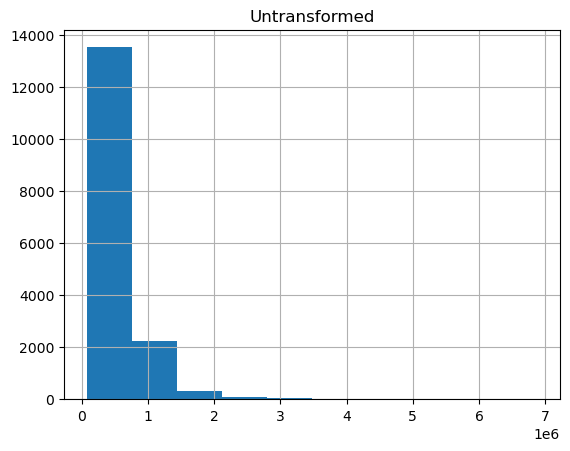

In [5]:
y_train.hist()
plt.title('Untransformed');

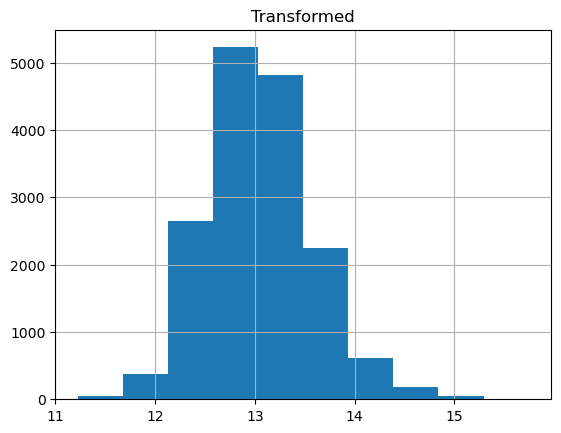

In [6]:
np.log(y_train).hist()
plt.title('Transformed');

If we want to apply a transformation to the target variable, the best way to do this so that we are making fair evaluations is to use a TransformedTargetRegressor.

In [7]:
from sklearn.compose import TransformedTargetRegressor

In [8]:
pipe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse_output = False), ['zipcode'])
            ],
            remainder = 'passthrough'
        )),
        ('scale', StandardScaler()),
        ('linreg', RidgeCV())
    ]
)

ttr = TransformedTargetRegressor(
    regressor = pipe,
    func = np.log,
    inverse_func = np.exp
)

ttr.fit(X_train, y_train)

print(f'R2 Score: {r2_score(y_test, ttr.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, ttr.predict(X_test))}')

R2 Score: 0.780326282358192
MAE: 75993.5668315916


In [9]:
non_zips = [x for x in X_train.columns if 'zipcode' not in x]
non_zips

X_train[non_zips].skew().sort_values(ascending = False)

sqft_lot                  13.487823
waterfront                11.256253
sqft_lot15                 9.914488
view                       3.376913
bedrooms                   2.411827
sqft_basement              1.601489
sqft_above                 1.432801
sqft_living                1.423941
sqft_living15              1.114869
condition                  1.017887
long                       0.888067
grade                      0.763457
floors                     0.613077
years_since_renovation     0.554662
bathrooms                  0.515211
age_at_sale                0.465991
lat                       -0.489128
dtype: float64

In [10]:
from sklearn.preprocessing import PowerTransformer

Let's see what it looks like before and after transforming the sqft_living variable using a PowerTransformer.

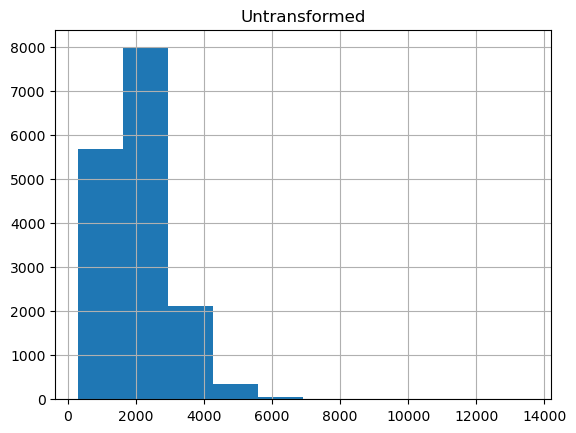

In [11]:
X_train['sqft_living'].hist()
plt.title('Untransformed');

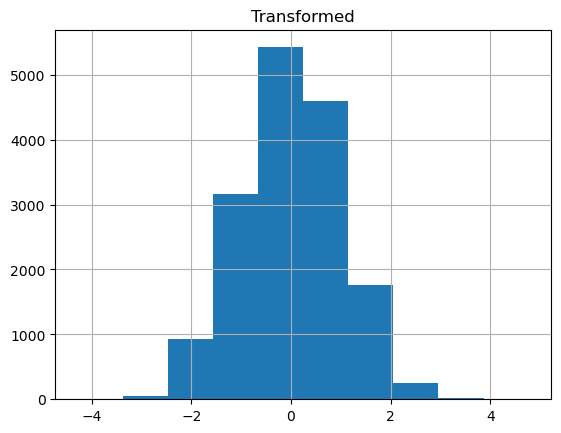

In [12]:
pd.Series(PowerTransformer().fit_transform(X_train[['sqft_living']])[:,0]).hist()
plt.title('Transformed');

In [13]:
transformed_columns = ['sqft_living', 'sqft_lot', 'bedrooms', 
                       'sqft_basement', 'sqft_above', 
                       'sqft_living', 'sqft_living15']

In [14]:
pipe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse_output = False), ['zipcode']),
                ('power', PowerTransformer(), transformed_columns)
            ],
            remainder = 'passthrough'
        )),
        ('scaler', StandardScaler()),
        ('linear', RidgeCV())
    ]
)

ttr = TransformedTargetRegressor(
    regressor = pipe,
    func = np.log,
    inverse_func = np.exp
)

ttr.fit(X_train, y_train)

print(f'R2 Score: {r2_score(y_test, ttr.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, ttr.predict(X_test))}')

R2 Score: 0.8834752089716618
MAE: 72165.07951077433


Now that we've gotten some baseline scores, let's see how we do using a neural network.

Because of the way that neural networks optimize their coefficients, it is useful to scale your variable values. In this case, we'll go with a MinMaxScaler, which will convert all variables to values between 0 and 1.

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
pipe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse_output = False), ['zipcode'])
            ],
            remainder = 'passthrough'
        )),
        ('scaler', MinMaxScaler()),
        ('mlr', MLPRegressor(verbose = True))
    ]
)

In [17]:
pipe.fit(X_train, y_train)

Iteration 1, loss = 214493268899.83187866
Iteration 2, loss = 214486973792.49792480
Iteration 3, loss = 214474639439.05169678
Iteration 4, loss = 214456003417.94931030
Iteration 5, loss = 214431084322.75415039
Iteration 6, loss = 214400196169.25198364
Iteration 7, loss = 214363678016.25280762
Iteration 8, loss = 214321249689.18853760
Iteration 9, loss = 214273052850.14315796
Iteration 10, loss = 214218923071.15353394
Iteration 11, loss = 214159527518.08032227
Iteration 12, loss = 214094818559.30670166
Iteration 13, loss = 214025119155.15847778
Iteration 14, loss = 213950474712.02163696
Iteration 15, loss = 213870932458.01715088
Iteration 16, loss = 213786519681.85806274
Iteration 17, loss = 213697503390.48532104
Iteration 18, loss = 213605036583.73599243
Iteration 19, loss = 213508341970.59326172
Iteration 20, loss = 213407084210.97467041
Iteration 21, loss = 213302038208.52423096
Iteration 22, loss = 213192822168.11038208
Iteration 23, loss = 213079518207.65890503
Iteration 24, loss =

Iteration 190, loss = 160669694577.12594604
Iteration 191, loss = 160217535414.19897461
Iteration 192, loss = 159766115664.30874634
Iteration 193, loss = 159313019309.16162109
Iteration 194, loss = 158859764455.86688232
Iteration 195, loss = 158405744860.76208496
Iteration 196, loss = 157950807143.55276489
Iteration 197, loss = 157494504025.93414307
Iteration 198, loss = 157037548742.33752441
Iteration 199, loss = 156578229758.82611084
Iteration 200, loss = 156119231326.22253418


/home/chunderdamus/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['zipcode'])])),
                ('scaler', MinMaxScaler()),
                ('mlr', MLPRegressor(verbose=True))])

In [18]:
print(f'R2 Score: {r2_score(y_test, pipe.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, pipe.predict(X_test))}')

R2 Score: -1.2934787352573456
MAE: 421911.20737560105


You very likely got a ConvergenceWarning, which indicated that the model thinks that it is not yet at a local minimum. You could up the max_iter value or you could take a different approach - add more layers.

Let's try adding a few layers to see if it improves the model's performance.

In [19]:
pipe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse_output = False), ['zipcode'])
            ],
            remainder = 'passthrough'
        )),
        ('scaler', MinMaxScaler()),
        ('mlr', MLPRegressor(verbose = True,
                            hidden_layer_sizes = (100, 100, 100),
                            max_iter = 1000))
    ]
)

pipe.fit(X_train, y_train)

Iteration 1, loss = 214446375815.56243896
Iteration 2, loss = 211708108547.24304199
Iteration 3, loss = 188309470275.87292480
Iteration 4, loss = 121237769413.71310425
Iteration 5, loss = 60580059867.26512909
Iteration 6, loss = 48494234602.15100098
Iteration 7, loss = 45555492162.63809204
Iteration 8, loss = 42940222737.85672760
Iteration 9, loss = 40461971772.63929749
Iteration 10, loss = 38026643669.46695709
Iteration 11, loss = 35653924970.72047424
Iteration 12, loss = 33318134533.87873840
Iteration 13, loss = 31057022821.38481903
Iteration 14, loss = 28869531830.42939758
Iteration 15, loss = 26836315692.93829346
Iteration 16, loss = 25037873070.86942673
Iteration 17, loss = 23440321777.07021332
Iteration 18, loss = 22085043494.44425583
Iteration 19, loss = 20968606339.44679260
Iteration 20, loss = 20054005336.14194107
Iteration 21, loss = 19299621457.73947525
Iteration 22, loss = 18665679337.56562805
Iteration 23, loss = 18110174280.36924744
Iteration 24, loss = 17631827682.499153

Iteration 198, loss = 6695119511.14528561
Iteration 199, loss = 6685657794.14170074
Iteration 200, loss = 6740596614.38184166
Iteration 201, loss = 6664457302.15088749
Iteration 202, loss = 6663301171.42912769
Iteration 203, loss = 6658104255.65540314
Iteration 204, loss = 6646758095.04771233
Iteration 205, loss = 6648250258.83138943
Iteration 206, loss = 6648326404.76194859
Iteration 207, loss = 6627705961.82690525
Iteration 208, loss = 6634505333.99898815
Iteration 209, loss = 6619654417.33040428
Iteration 210, loss = 6625362400.93532372
Iteration 211, loss = 6608737528.68699169
Iteration 212, loss = 6600731460.32384872
Iteration 213, loss = 6608045219.89429092
Iteration 214, loss = 6595251952.62160301
Iteration 215, loss = 6591770154.99048710
Iteration 216, loss = 6608966496.83252430
Iteration 217, loss = 6585091206.91355133
Iteration 218, loss = 6582204040.93756294
Iteration 219, loss = 6579006843.59589767
Iteration 220, loss = 6587256850.78164196
Iteration 221, loss = 6572268199.1

Iteration 394, loss = 6017284325.32444000
Iteration 395, loss = 6026513588.66786098
Iteration 396, loss = 6033145370.52208233
Iteration 397, loss = 6023093927.80777168
Iteration 398, loss = 6017301906.03683949
Iteration 399, loss = 6028553158.05346203
Iteration 400, loss = 6022854112.97609711
Iteration 401, loss = 6024678201.20499992
Iteration 402, loss = 6013491772.28709888
Iteration 403, loss = 6018718415.78270149
Iteration 404, loss = 6002659663.85167027
Iteration 405, loss = 6011016902.76566601
Iteration 406, loss = 6023428844.90604019
Iteration 407, loss = 6000823385.69060421
Iteration 408, loss = 6000215125.69026852
Iteration 409, loss = 5997334961.09694672
Iteration 410, loss = 5992576101.18709278
Iteration 411, loss = 5997532516.52229977
Iteration 412, loss = 5987571300.44290829
Iteration 413, loss = 5998813784.08368206
Iteration 414, loss = 5987492792.23596859
Iteration 415, loss = 5991272034.54557705
Iteration 416, loss = 5978196577.57274532
Iteration 417, loss = 5997555659.7

Iteration 590, loss = 5699209215.34449291
Iteration 591, loss = 5682793276.13848114
Iteration 592, loss = 5687895329.98910999
Iteration 593, loss = 5681331354.76529503
Iteration 594, loss = 5678614463.83677673
Iteration 595, loss = 5675356951.14858723
Iteration 596, loss = 5680192046.26519299
Iteration 597, loss = 5670537746.80360031
Iteration 598, loss = 5677801738.87991714
Iteration 599, loss = 5669684643.91552353
Iteration 600, loss = 5710017944.43685913
Iteration 601, loss = 5674005879.37246037
Iteration 602, loss = 5670548063.61918068
Iteration 603, loss = 5665656567.29539776
Iteration 604, loss = 5678385518.05274677
Iteration 605, loss = 5661693609.18216991
Iteration 606, loss = 5677291858.52940083
Iteration 607, loss = 5670522962.18792820
Iteration 608, loss = 5666659123.13852978
Iteration 609, loss = 5658728464.24368668
Iteration 610, loss = 5653367920.15905285
Iteration 611, loss = 5658744370.24449539
Iteration 612, loss = 5652208154.47225094
Iteration 613, loss = 5658435546.0

Iteration 786, loss = 5476735827.66880989
Iteration 787, loss = 5443194811.94010448
Iteration 788, loss = 5442628769.30743504
Iteration 789, loss = 5444902072.68792343
Iteration 790, loss = 5434768984.67075157
Iteration 791, loss = 5438188928.09463882
Iteration 792, loss = 5433664526.54336929
Iteration 793, loss = 5434642946.83041096
Iteration 794, loss = 5437043744.03356934
Iteration 795, loss = 5446325085.68014717
Iteration 796, loss = 5429455122.60069466
Iteration 797, loss = 5426014184.56389046
Iteration 798, loss = 5432476839.60197163
Iteration 799, loss = 5427891389.05383301
Iteration 800, loss = 5431115156.13673210
Iteration 801, loss = 5424429228.05721855
Iteration 802, loss = 5608414799.14784908
Iteration 803, loss = 5438020240.68845463
Iteration 804, loss = 5431271442.37080288
Iteration 805, loss = 5426695678.13029385
Iteration 806, loss = 5421559905.63333225
Iteration 807, loss = 5469828043.46114731
Iteration 808, loss = 5422837768.28105259
Iteration 809, loss = 5426160896.2

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['zipcode'])])),
                ('scaler', MinMaxScaler()),
                ('mlr',
                 MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000,
                              verbose=True))])

In [20]:
print(f'R2: {r2_score(y_test, pipe.predict(X_test))}')

print(f'MAE: {mean_absolute_error(y_test, pipe.predict(X_test))}')

R2: 0.9004828944616214
MAE: 68216.77280436724


If you look at the documentation, you'll see that there is a regularization parameter, alpha, that you can experiment with. Let's see what happens if we up the regularization strength.

In [21]:
pipe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse = False), ['zipcode'])
            ],
            remainder = 'passthrough'
        )),
        ('scaler', MinMaxScaler()),
        ('mlr', MLPRegressor(verbose = True,
                            hidden_layer_sizes = (100, 100, 100),
                            alpha = 1))
    ]
)

pipe.fit(X_train, y_train)

/home/chunderdamus/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Iteration 1, loss = 214439584211.13046265
Iteration 2, loss = 211446214557.27865601
Iteration 3, loss = 186450667284.81460571
Iteration 4, loss = 116788891267.89837646
Iteration 5, loss = 58586530218.30842590
Iteration 6, loss = 48416548361.87715149
Iteration 7, loss = 45488158594.10810089
Iteration 8, loss = 42875897008.29780579
Iteration 9, loss = 40351576447.22069550
Iteration 10, loss = 37944387883.44359589
Iteration 11, loss = 35615334245.23084259
Iteration 12, loss = 33304716486.16822815
Iteration 13, loss = 31055448199.94443130
Iteration 14, loss = 28880902652.49218750
Iteration 15, loss = 26744437449.11315536
Iteration 16, loss = 24943062539.18326950
Iteration 17, loss = 23378472120.60259628
Iteration 18, loss = 22100918802.40992737
Iteration 19, loss = 21035922035.88861465
Iteration 20, loss = 20196879523.06029129
Iteration 21, loss = 19508237509.60660172
Iteration 22, loss = 18879779473.49566269
Iteration 23, loss = 18375601152.20825577
Iteration 24, loss = 18007351900.917163

Iteration 198, loss = 6704770092.61662674
Iteration 199, loss = 6727711550.46168613
Iteration 200, loss = 6692158519.39381027


/home/chunderdamus/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  ['zipcode'])])),
                ('scaler', MinMaxScaler()),
                ('mlr',
                 MLPRegressor(alpha=1, hidden_layer_sizes=(100, 100, 100),
                              verbose=True))])

In [22]:
print(f'R2: {r2_score(y_test, pipe.predict(X_test))}')

print(f'MAE: {mean_absolute_error(y_test, pipe.predict(X_test))}')

R2: 0.8885222564231849
MAE: 71798.79592319304
